INFO: Pandarallel will run on 19 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


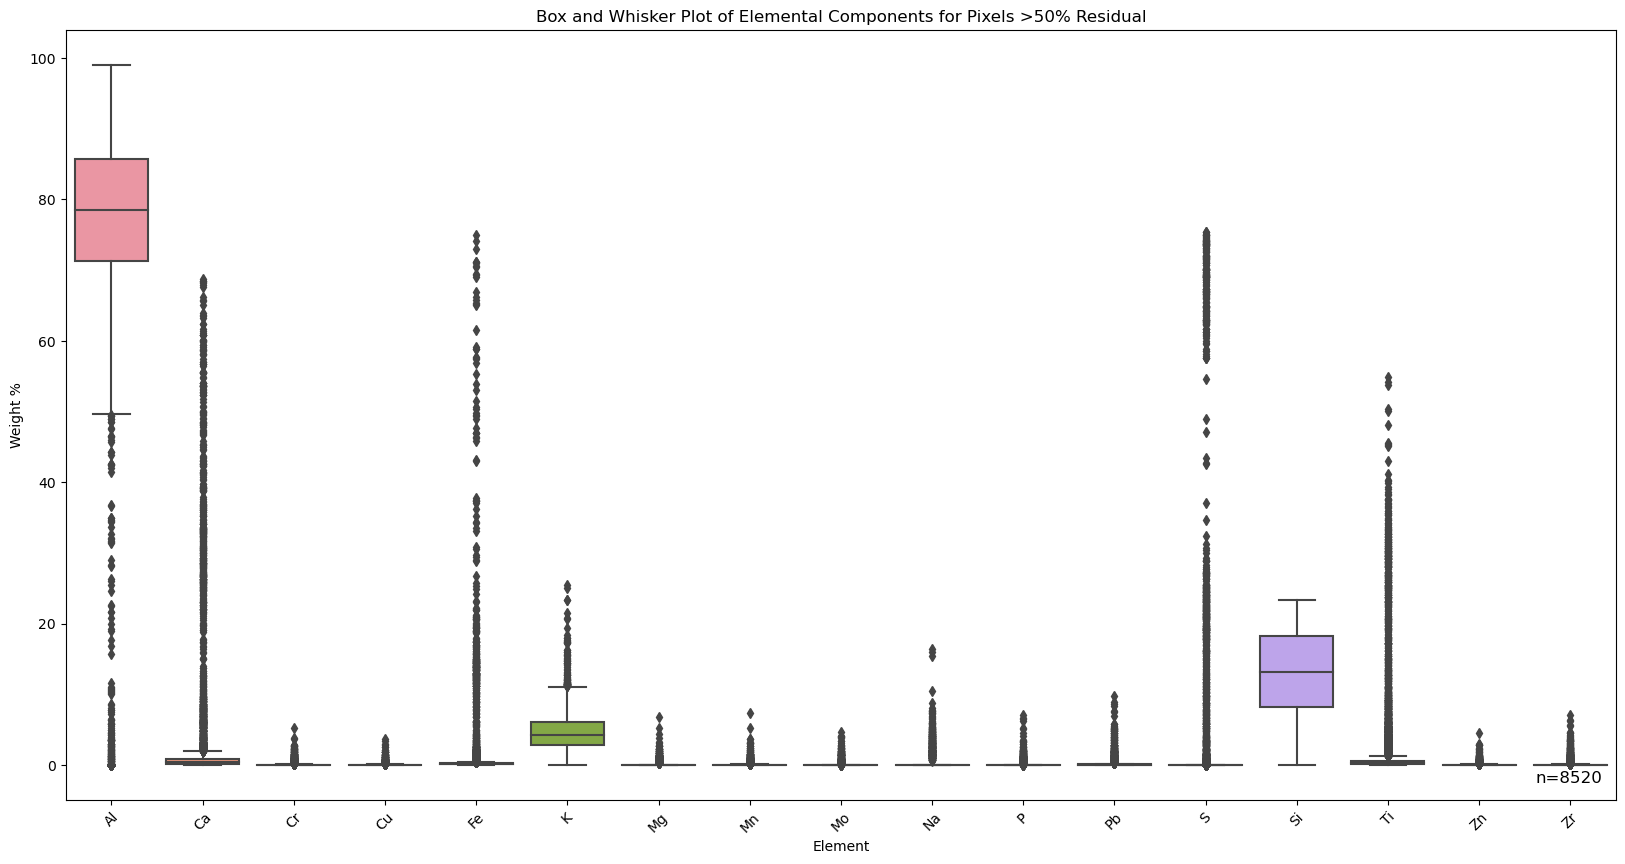

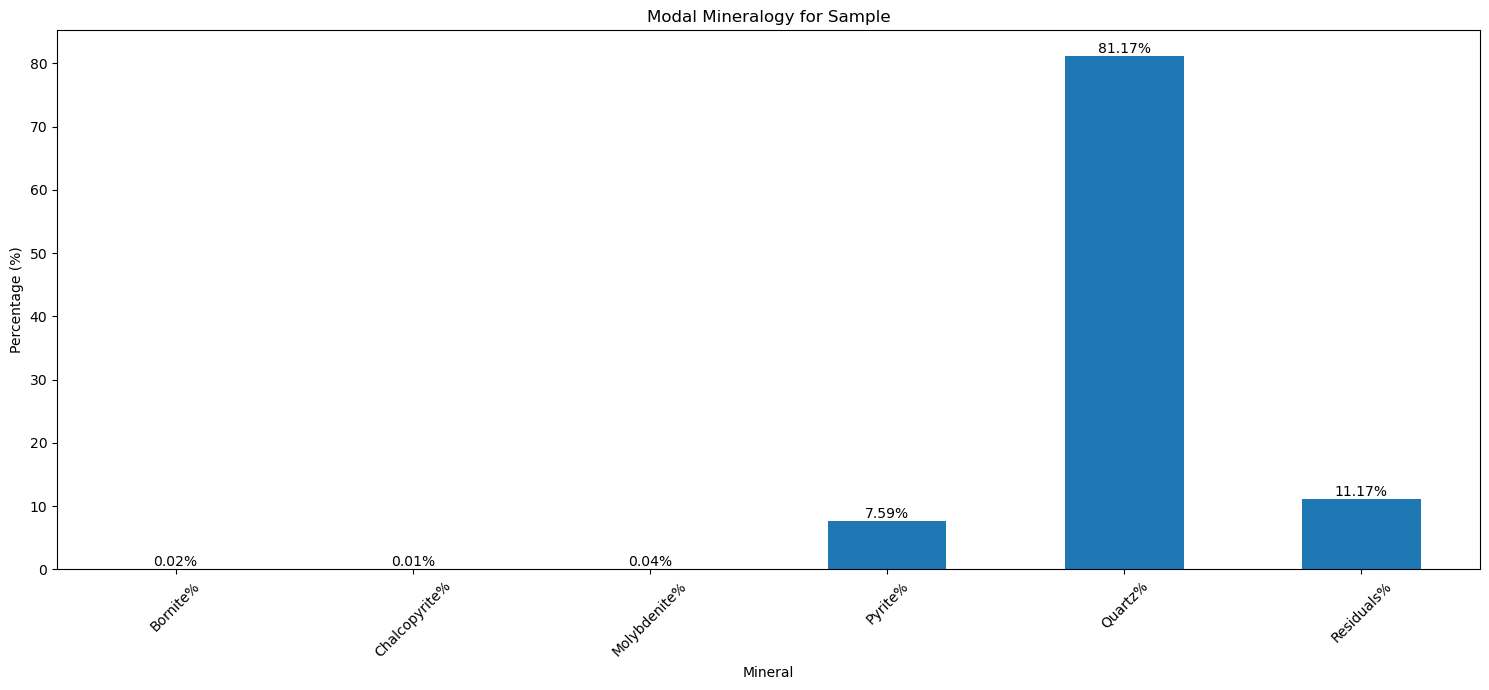

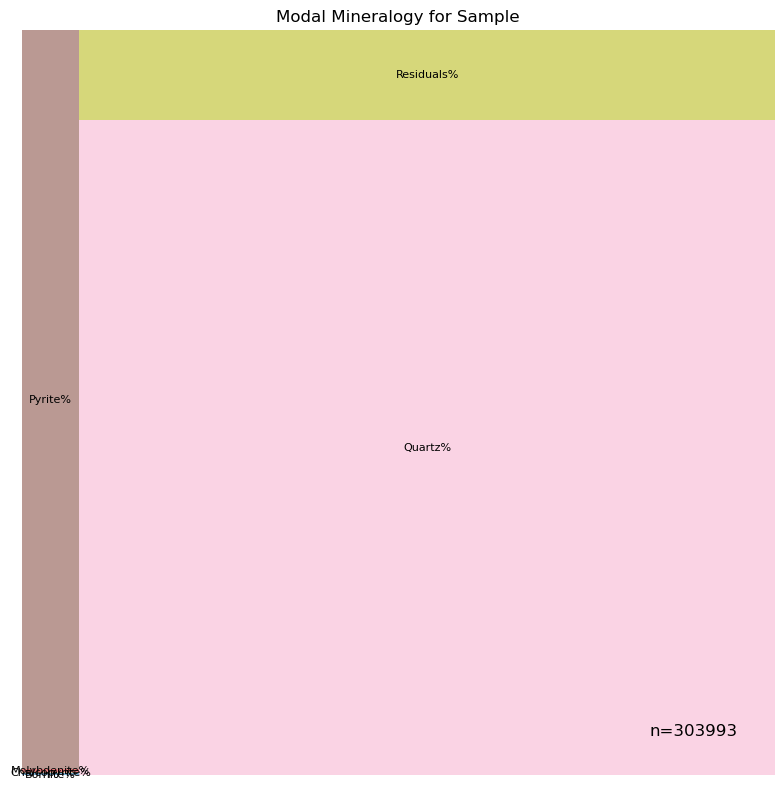

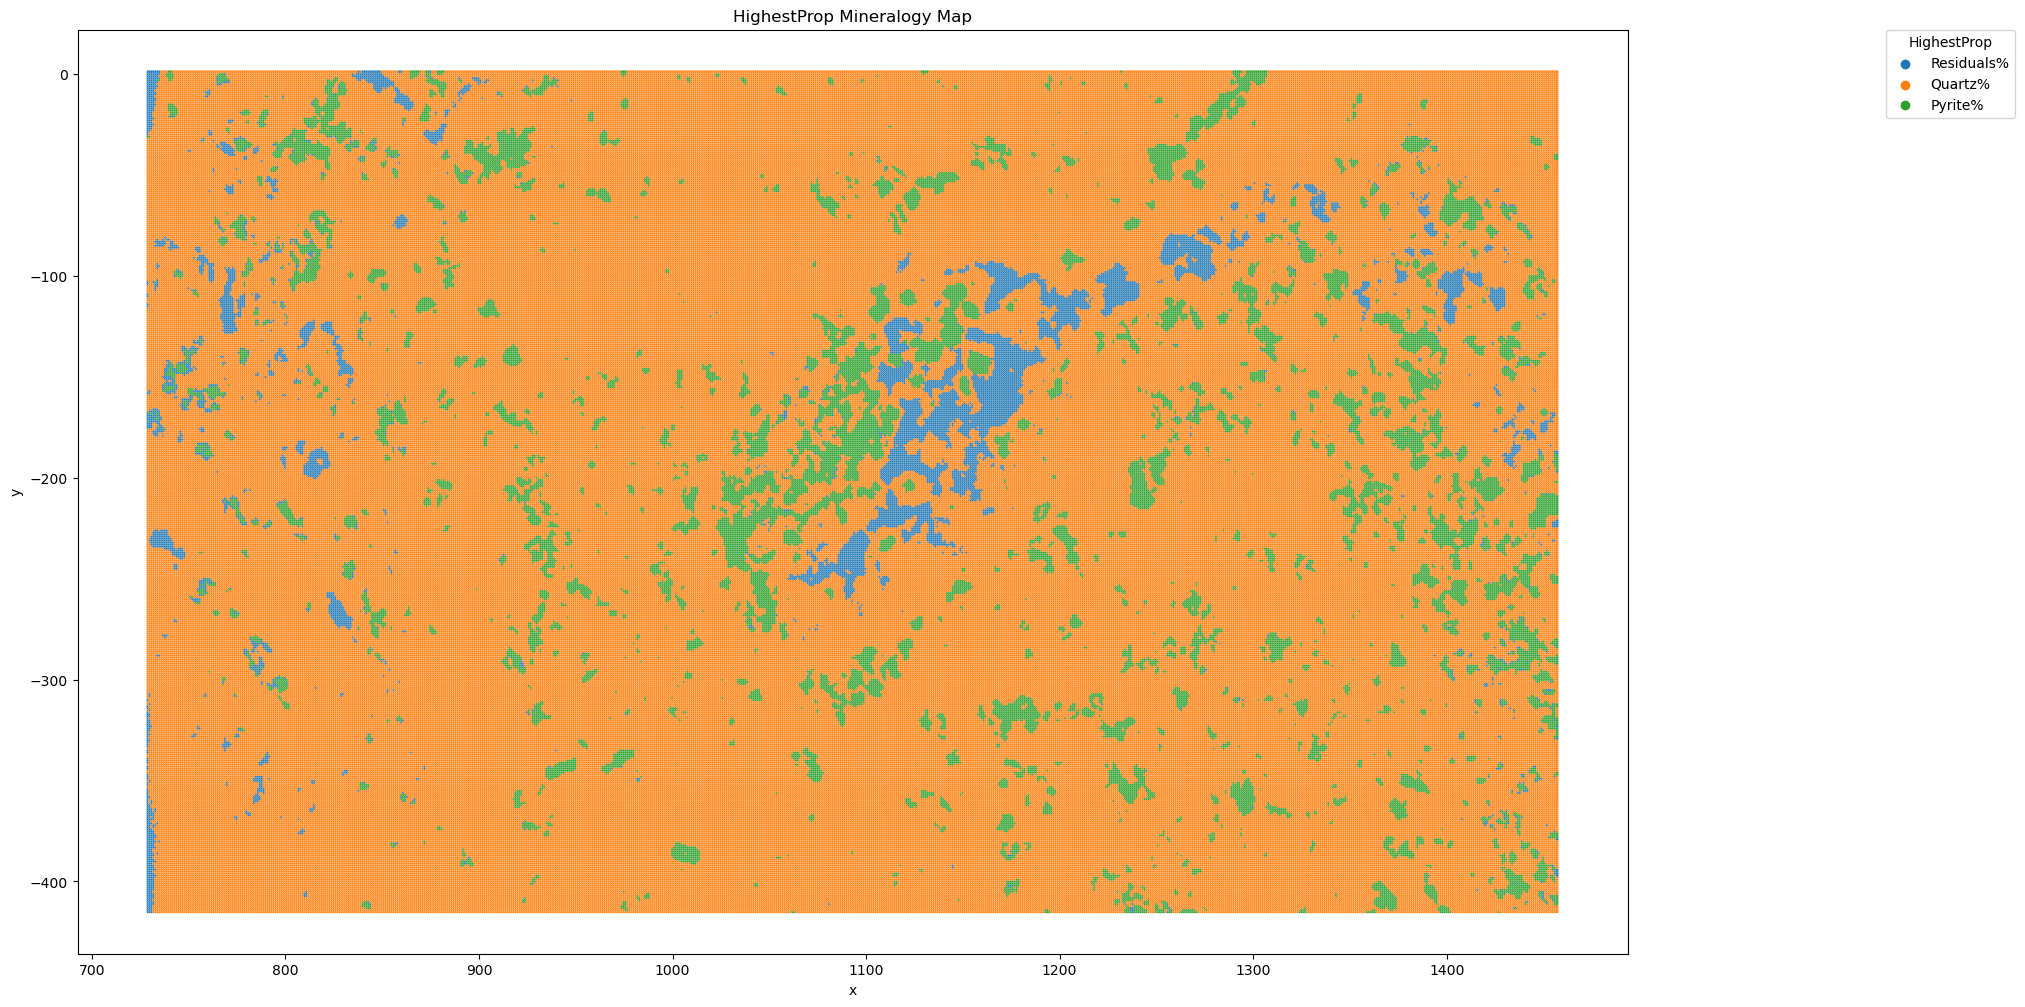

In [1]:
#Linear programming - set up to run micro-XRF or other datasets where the incoming CSV has X, Y coordinates and elemental data in weight % with column headers as Al, Si, K, etc. (for other header names, must modify code)
#Code developed by Cassady Harraden, Mineral Deposit Research Unit, University of British Columbia, April 2024
#USER MUST CHECK/MODIFY:
#Lines 27-29: folder path where file is stored (make sure "\" are changed to "/"), incoming file with elemental data, and name of output file
#Lines 42-127: check that minerals have the correct formulas for your application (especially solid solution minerals) + add any minerals you want included
#Lines 133-218: comment out (add a "#" in front of) any minerals you want excluded from the mineral library. NO NEED TO COMMENT OUT IN LINES 41-126
#Once these are done, execute the code by clicking in this box, hold down the "SHIFT" key, and hit the "ENTER" key
#NOTE: this code is set up to use MOST of the processing capacity of your computer - if you are doing other tasks, this will slow your computer/processing down significantly
#NOTE: the code WILL NOT warn you if an element is missing for a mineral - it will continue calculating with the other elements - so, for example, if you have zircon active, but Zr is not included in the incoming elemental data, 
#      the algorithm will only use Si and, in this case, you will have zircon mapped where quartz should probably be - YOU MUST THINK ABOUT YOUR SELECTIONS AND PROPER GEOLOGY/MINERALOGY CONTEXT FOR THIS TO WORK

import pandas as pd
import numpy as np
from pandarallel import pandarallel
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Get the number of available processors
num_processors_available = multiprocessing.cpu_count()
num_processors_to_use = max(1, num_processors_available - 1)

# Initialize parallel processing
pandarallel.initialize(nb_workers=num_processors_to_use, progress_bar=True)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>USER INPUT: set the path of the folder where the CSV file is located<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
folder_path = 'C:/Users/charraden/OneDrive - UBC/BCPorphyryProject/CalculatedMineralogy/LP_Paper_24April2024/CodeDistribution_AppendixB'
importfile_name = '19FB-131_MassPctNorm.csv'
exportfile_name = '19FB-131_MassPctNorm_LP.csv'
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

df = pd.read_csv(folder_path + '/' + importfile_name)

df_list = []

# Define the linear programming process
def process_row(row):
    
#>>>>>>>>>>>>>>>>>>>>>USER INPUT: check mineral formulas (change elemental values if required) + add any minerals you want included using the proper syntax 
#                     (order of elements and minerals doesn't matter) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    mineral_elements = {
        "Actinolite": {"Al": 1.39, "Si": 25.64, "Ca": 8.6, "Fe": 8.58, "Mg": 9.71},
        "Albite": {"Si": 31.5, "Al": 10.77, "Na": 8.3, "Ca": 0.76},
        "Almandine": {"Al": 10.84, "Si": 16.93, "Fe": 33.66},
        "Alunite": {"K": 9.44, "Al": 19.54, "S": 15.48},
        "Anandite": {"Ba": 17.36, "Mg": 3.07, "Al": 3.18, "Fe": 24.01, "Si": 14.20, "S": 8.11},
        "Andalusite": {"Al": 33.3, "Si": 17.33},
        "Andradite": {"Si": 14.73, "Ca": 21.01, "Fe": 19.52},
        "Anhydrite": {"S": 23.55, "Ca": 29.44},
        "Ankerite": {"Mn": 2.66, "Mg": 3.53, "Fe": 16.24, "Ca": 19.42},
        "Anorthite": {"Al": 18.97, "Si": 20.75, "Ca": 13.72}, 
        "Apatite": {"P": 18.25, "Ca": 39.36},
        "Argentite": {"S": 12.94, "Ag": 87.06},
        "Arsenopyrite": {"Fe": 34.3, "S": 19.69, "As": 46.01},
        "Augite": {"Al": 4.57, "Ca": 15.26, "Fe": 4.73, "Mg": 9.26, "Si": 22.58, "Ti": 2.03},
        "Barite": {"S": 13.74, "Ba": 58.84},
        "Beryl": {"Al": 10.04, "Si": 31.35, "Be": 5.03},
        "Biotite": {"Si": 19.44, "Mg": 14.02, "K": 9.02, "Fe": 6.44, "Al": 6.22},
        "Bornite": {"Fe": 11.13, "Cu": 63.31, "S": 25.56}, 
        "Calcite": {"Ca": 40.04},
        "Celadonite": {"K": 9.11, "Si": 26.19, "Fe": 14.32, "Mg": 4.53},
        "Chalcocite": {"Cu": 79.85, "S": 20.15},
        "Chalcopyrite": {"S": 34.94, "Fe": 30.43, "Cu": 34.64},
        "Chalcanthite": {"Cu": 25.45, "S": 12.84},
        "Changoite": {"Na": 12.24, "Zn": 17.41, "S": 17.08},
        "Chrysocolla": {"Al": 2.05, "Cu": 33.86, "Si": 17.10},
        "Clinozoisite": {"Al": 17.82, "Si": 18.54, "Ca": 17.64},
        "Corundum": {"Al": 52.93},
        "Covellite": {"Cu": 66.46, "S": 33.54},
        "Diaspore": {"Al": 44.98},
        "Diopside": {"Ca": 18.51, "Mg": 11.22, "Si": 25.94},
        "Dioptase": {"Si": 17.82, "Cu": 40.13},
        "Dolomite": {"Ca": 21.73, "Mg": 13.18},
        "Dumortierite": {"Al": 32.68, "Si": 14.79},
        "Elbaite": {"Al": 19.13, "Si": 18.38, "Na": 2.51, "B": 3.54},
        "Enargite": {"Cu": 48.41, "S": 32.57, "As": 19.02},
        "Enstatite": {"Mg": 24.21, "Si": 27.98},
        "Epidote": {"Si": 16.22, "Fe": 24.20, "Ca": 15.44, "Al": 3.90},
        "FeChlorite": {"Si": 10.73, "Mg": 2.26, "Fe": 32.81, "Al": 10.27},
        "Galena": {"S": 13.4, "Pb": 86.6},
        "Glauconite": {"K": 5.49, "Al": 1.9, "Si": 25.0, "Fe": 19.62, "Mg": 2.28}, 
        "Grossular": {"Al": 11.98, "Si": 18.71, "Ca": 26.69},
        "Grunerite": {"Si": 22.43, "Fe": 39.03},
        "Hematite": {"Fe": 69.94},
        "Jarosite": {"K": 7.81, "Fe": 33.45, "S": 12.81},
        "Kaolinite": {"Si": 21.76, "Al": 20.90},
        "Kspar": {"Si": 30.27, "Al": 9.69, "K": 14.05},
        "Kyanite": {"Al": 33.3, "Si": 17.33},
        "Lazurite": {"Al": 16.24, "Si": 16.91, "Na": 13.84, "Ca": 8.04, "S": 6.43},
        "Magnesiohornblende": {"Si": 23.94, "Mg": 11.84, "Fe": 1.7, "Ca": 9.67, "Al": 5.75},
        "Magnesite": {"Mg": 28.83},
        "Magnetite": {"Fe": 72.36},
        "Malachite": {"Cu": 57.48},
        "MgChlorite": {"Si": 12.61, "Mg": 12.93, "Fe": 11.31, "Al": 11.61},
        "Molybdenite": {"S": 40.06, "Mo": 59.94},
        "Montmorillonite": {"Al": 9.83, "Si": 20.46}, 
        "Muscovite": {"Si": 21.13, "K": 9.81, "Al": 20.30},
        "Oligoclase": {"Al": 12.2, "Si": 29.63, "Na": 6.93, "Ca": 3.02},
        "Olivine": {"Si": 18.32, "Fe": 14.57, "Mg": 25.37},
        "Paragonite": {"Al": 21.18, "Si": 22.05, "Na": 6.02},
        "Pentlandite":{"Fe": 32.56, "S": 33.23, "Ni": 34.21},
        "Plagioclase": {"Si": 31.12, "Na": 4.25, "Ca": 7.4, "Al": 9.96},
        "Proustite": {"S": 19.44, "Ag": 65.41, "As": 15.14},
        "Pyrite": {"S": 53.45, "Fe": 46.55},
        "Pyrope": {"Al": 13.39, "Si": 20.9, "Mg": 18.09},
        "Pyrophyllite": {"Si": 31.18, "Al": 14.98},
        "Pyrrhotite": {"Fe": 62.33, "S": 37.67},
        "Quartz": {"Si": 46.74},
        "Rhodonite": {"Si": 21.75, "Ca": 1.55, "Mn": 38.29},
        "Rutile": {"Ti": 59.94},
        "Scapolite": {"Al": 15.38, "Si": 22.42, "Na": 5.24, "Ca": 9.14, "Cl": 4.04},
        "Schorl": {"Al": 15.37, "Si": 16.0, "Na": 2.18, "Fe": 15.91, "B": 3.08},
        "Siderite": {"Fe": 48.2},
        "Sillimanite": {"Al": 33.3, "Si": 17.33},
        "Sodalite": {"Al": 16.7, "Si": 17.39, "Na": 18.98, "Cl": 7.32},
        "Spessartine": {"Al": 10.9, "Si": 17.02, "Mn": 33.29},
        "Sphalerite": {"Fe": 2.88, "S": 33.06, "Zn":  64.06},
        "Staurolite": {"Al": 28.91, "Si": 13.49, "Fe": 9.63},
        "Sudoite": {"Al": 19.25, "Si": 15.41, "Fe": 3.06, "Mg": 8.45},
        "Tennantite": {"Fe": 3.8, "Cu": 47.51, "S": 28.33, "As": 20.37},
        "Tetrahedrite": {"Fe": 10.2, "Cu": 34.8, "S": 25.37, "As": 29.64},
        "Titanite": {"Si": 14.2, "Ca": 19.25, "Ti": 18.16},
        "Topaz": {"Al": 29.29, "Si": 15.41, "F": 11.47},
        "Vesuvianite": {"Al": 7.59, "Si": 17.77, "Ca": 28.18, "Mg": 3.42},
        "Wollastonite": {"Si": 24.18, "Ca": 34.5},
        "Zircon": {"Si": 14.76, "Zr": 43.14},
        "Zunyite": {"Al": 30.32, "Si": 12.14, "F": 3.28, "Cl": 3.06}             
    }
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

#>>>>>>>>>>>>>>     USER: Comment out (put a # before the text) minerals you wish to exclude from the library AND 
#                   make sure there is a "]" bracket (and no comma) after the last active mineral     <<<<<<<<<<<<<<<<<<<<<<<<<<< 
    active_minerals = [#"Actinolite",
                       #"Albite",
                       #"Almandine",
                       #"Alunite",
                       #"Anandite",
                       #"Andalusite",
                       #"Andradite",
                       #"Anhydrite",
                       #"Ankerite",
                       #"Anorthite", 
                       #"Apatite",
                       #"Argentite",
                       #"Arsenopyrite",
                       #"Augite",
                       #"Barite",
                       #"Beryl",
                       #"Biotite",
                       "Bornite", 
                       #"Calcite",
                       #"Celadonite",
                       #"Chalcocite",
                       "Chalcopyrite",
                       #"Chalcanthite",
                       #"Changoite",
                       #"Chrysocolla",
                       #"Clinozoisite",
                       #"Corundum",
                       #"Covellite",
                       #"Diaspore",
                       #"Dioptase",
                       #"Diopside",
                       #"Dolomite",
                       #"Dumortierite",
                       #"Elbaite",
                       #"Enargite",
                       #"Enstatite",
                       #"Epidote",
                       #"FeChlorite",
                       #"Galena",
                       #"Glauconite", 
                       #"Grossular",
                       #"Grunerite",
                       #"Hematite",
                       #"Jarosite",
                       #"Kaolinite",
                       #"Kspar",
                       #"Kyanite",
                       #"Lazurite",
                       #"Magnesiohornblende",
                       #"Magnesite",
                       #"Magnetite",
                       #"Malachite",
                       #"MgChlorite", 
                       "Molybdenite",
                       #"Montmorillonite", 
                       #"Muscovite",
                       #"Oligoclase",
                       #"Olivine",
                       #"Paragonite",
                       #"Pentlandite",
                       #"Plagioclase",
                       #"Proustite",
                       "Pyrite",
                       #"Pyrope",
                       #"Pyrophyllite",
                       #"Pyrrhotite",
                       "Quartz"]
                       #"Rhodonite",
                       #"Rutile",
                       #"Scapolite",
                       #"Schorl",
                       #"Siderite",
                       #"Sillimanite",
                       #"Sodalite",
                       #"Spessartine",
                       #"Sphalerite",
                       #"Staurolite",
                       #"Sudoite",
                       #"Tennantite",
                       #"Tetrahedrite",
                       #"Titanite",
                       #"Topaz",
                       #"Vesuvianite",
                       #"Wollastonite",
                       #"Zircon"
                       #"Zunyite"]        
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    from docplex.mp.model import Model
    m = Model(name='Mineralogy')
    minerals = {mineral: m.continuous_var(name=mineral, lb=0) for mineral in active_minerals}
    elements = {}
    for mineral in active_minerals:
        for element, _ in mineral_elements[mineral].items():
            element_key = element
            if element_key in row.index:
                elements[element] = row[element_key]
    for element in elements:
        element_constraint = m.sum(minerals[mineral] * mineral_elements[mineral].get(element, 0)
                                   for mineral in active_minerals if element in mineral_elements[mineral])
        m.add_constraint(element_constraint <= elements[element], f"{element}_constraint")
    m.add_constraint(m.sum(minerals.values()) <= 1, "TotalMineralConstraint")
    m.set_objective("max", m.sum(minerals.values()))
    
    sol_dict = {}
    if m.solve():
        for mineral in active_minerals:
            sol_dict[f"{mineral}%"] = minerals[mineral].solution_value * 100
        sol_dict['Residuals%'] = 100 - sum(sol_dict.values())
        sol_dict['HighestProp'] = max(sol_dict, key=sol_dict.get)
    else:
        sol_dict = {f"{mineral}%": 0 for mineral in active_minerals}
        sol_dict['Residuals%'] = 100
        sol_dict['HighestProp'] = None
    return sol_dict

# Apply the LP function to each row in parallel
result_series = df.parallel_apply(process_row, axis=1)

# Convert the dictionaries to a DataFrame
result_df = pd.DataFrame(list(result_series))

# Concatenate the original DataFrame with the results
output_df = pd.concat([df.reset_index(drop=True), result_df], axis=1)

# Save the output DataFrame to a new CSV file
output_df.to_csv(folder_path + '/' + exportfile_name, index=False)

# All columns in the DataFrame
all_columns = output_df.columns.tolist()

#>>>>>>>>>>>>>>>>>>> END OF LINEAR PROGRAMMING - PLOTTING FUNCTIONS BELOW <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Elemental columns are all columns except 'X', 'Y', and those containing '%'
elemental_columns = [col for col in all_columns if col not in ['x', 'y', 'Video'] and '%' not in col]

# Find and report chemistry for >50% residuals for elemental analysis
high_residuals_df = output_df[output_df['Residuals%'] > 50]

# Select only the elemental data from rows with >50% residuals
elemental_data_for_plotting = high_residuals_df[elemental_columns]

# Create the box and whisker plot
import seaborn as sns
import matplotlib.pyplot as plt
num_rows = len(elemental_data_for_plotting)
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.boxplot(data=elemental_data_for_plotting)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.title('Box and Whisker Plot of Elemental Components for Pixels >50% Residual')
plt.ylabel('Weight %')
plt.xlabel('Element')
plt.annotate(f'n={num_rows}', xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom', fontsize=12, xytext=(-10, 10), textcoords='offset points')
plt.show()

# Calculate the total percentages for each mineral across all rows.
mineral_percentage_columns = [col for col in result_df.columns if '%' in col and col]
total_minerals_percent = result_df[mineral_percentage_columns].sum()

# Normalize the percentages to account for the total proportion of each mineral across the entire dataset
total_minerals_percent_normalized = (total_minerals_percent / total_minerals_percent.sum()) * 100

#Generate the histogram of modal mineralogy
plt.figure(figsize=(15, 7))  # Adjust the figure size as needed
total_minerals_percent_normalized.plot(kind='bar')
plt.title('Modal Mineralogy for Sample')
plt.ylabel('Percentage (%)')
plt.xlabel('Mineral')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
for index, value in enumerate(total_minerals_percent_normalized):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

import squarify
filtered_minerals_percent_normalized = total_minerals_percent_normalized[total_minerals_percent_normalized > 0]
values = filtered_minerals_percent_normalized.values
labels = filtered_minerals_percent_normalized.index
colors = [plt.cm.tab20(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(8, 8))
squarify.plot(sizes=values, label=labels, color=colors, alpha=0.6, text_kwargs={'fontsize':8})
plt.title('Modal Mineralogy for Sample')
total_pixels = result_df.shape[0]  # Assuming result_df is defined, representing the number of analyzed pixels
plt.annotate(f'n={total_pixels}', xy=(0.95, 0.05), xycoords='axes fraction', ha='right', va='bottom', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 12))
scatter_plot = sns.scatterplot(data=output_df, x='x', y='y', hue='HighestProp', s=5)
plt.title('HighestProp Mineralogy Map')
plt.legend(title='HighestProp', loc='upper right', bbox_to_anchor=(1.25, 1), borderaxespad=0.)
plt.show()